#Project 3 Multi-label Classification of Image Data
  Group 92

##Prelude
  - Importing libraies
  - Loading data
  - Pre-processing data

In [1]:
import numpy as np
import torch
import math
import torch.nn.functional as F
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

In [2]:
# use GPU to perform main computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

cuda:0


###Help function to visualize the data 

In [25]:
def plot_images(images, nrows, ncols, cls_pred=None):
    
    # Initialize figure
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    
    for i, ax in enumerate(axes.flat): 
        
      if cls_pred is not None:
          # Pretty string with predicted number
          pred_number = ''.join(str(x) for x in cls_pred[i] if x != 10)
          title = "Pred: {0}".format(pred_number) 
          ax.set_title(title) 
            
      ax.imshow(images[i,:,:,0])  
      ax.set_xticks([]);
      ax.set_yticks([])

### Import and pre-process data
 - Display data examples
 - Convert data to tensor flow and put data into cuda device

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
filename = '/content/drive/MyDrive/MNIST_synthetic.h5'

# Read dataset to numpy array from h5 file
hf = h5py.File(filename, 'r')

x_train = np.array(hf["train_dataset"][:])
y_train = np.array(hf["train_labels"][:])
x_test = np.array(hf["test_dataset"][:])

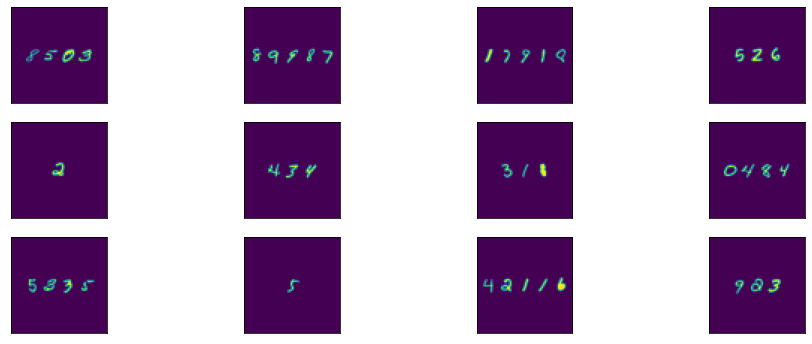

In [28]:
# Plot some sample images
plot_images(x_train, 3, 4);

In [7]:
# Convert data to float32
x_train = np.float32(np.array(hf["train_dataset"][:]) )
y_train = np.float32(np.array(hf["train_labels"][:]))
x_test = np.float32(np.array(hf["test_dataset"][:]) )

In [8]:
# Resize the dataset
x_train = x_train.flatten().reshape(56000,1,64,64)
x_test = x_test.flatten().reshape(14000,1,64,64)

In [9]:
# Split the train data and validation data 
def process_data(train, label,test, percentage):
    length = train.shape[0]
    split = math.floor(length* percentage)
    train_set_x = train[:split]
    train_set_y = label[:split]
    val_set_x = train[split:]
    val_set_y = label[split:]
    train_set_x=  (train_set_x - np.mean(train_set_x))/np.std(train_set_x)
    val_set_x=  (val_set_x - np.mean(val_set_x))/np.std(val_set_x)
    test = (test- np.mean(test))/np.std(test)

    x_train, y_train, x_valid, y_valid, x_test = map(
        torch.tensor, (train_set_x,train_set_y,val_set_x,val_set_y,test)
        )
    return x_train,y_train,x_valid,y_valid, x_test

In [10]:
# Declare the percentage to be trained
train_percentage = 0.9
x_train, y_train, x_valid, y_valid, x_test = process_data(x_train, y_train,x_test,train_percentage)

x_train = x_train.float()
x_test = x_test.float()
y_train = F.one_hot(y_train.long(),11).float()
y_valid = F.one_hot(y_valid.long(),11).float()

In [11]:
# move data to GPU device
x_train = x_train.to(device,dtype=torch.float)
y_train = y_train.to(device,dtype=torch.float)
x_valid = x_valid.to(device,dtype=torch.float)
y_valid = y_valid.to(device,dtype=torch.float)
x_test = x_test.to(device,dtype=torch.float)

In [12]:
# put tensors related to train into dataset
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
test_ds = TensorDataset(x_test)

# put the dataset into dataloader and declare the batch size
bs = 128
train_dl = DataLoader(train_ds, batch_size=bs)
valid_dl = DataLoader(valid_ds, bs*2)
test_dl = DataLoader(test_ds,bs)

In [13]:
# check if data are successfully put to device
print(x_train.is_cuda , y_train.is_cuda , x_valid.is_cuda, y_valid.is_cuda)

True True True True


## Define CNN
 - leNet architecture

In [14]:
class Mnist_cnn1(nn.Module):
    def __init__(self):
        super().__init__()

        self._hidden1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
            nn.ReLU(),
        )
        self._hidden2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),

        )

        self._hidden3 = nn.Sequential(
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU()
        )
        self._hidden4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
        )
        self._hidden5 = nn.Sequential(
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25)
        )
      
        self._hidden6 = nn.Sequential(
            nn.Linear(9216, 256),
        )
        self._hidden7 = nn.Sequential(
            nn.ReLU()
        )
        self._hidden8 = nn.Sequential(
            nn.Linear(256,128)
        )
        self._hidden9 = nn.Sequential(
            nn.ReLU()
        )
        self._hidden10 = nn.Sequential(
            nn.Linear(128,84)
        )
        self._hidden11 = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.25)
        )

        self.digit1 = nn.Linear(84, 11)
        self.digit2 = nn.Linear(84, 11)
        self.digit3 = nn.Linear(84, 11)
        self.digit4 = nn.Linear(84, 11)
        self.digit5 = nn.Linear(84, 11)
              

    def forward(self, x):
        s = nn.Softmax(dim =1 )

        x = self._hidden1(x)
        x = self._hidden2(x)
        x = self._hidden3(x)
        x = self._hidden4(x)
        x = self._hidden5(x)
        x= x.view(-1,self.num_flat_features(x))
        x = self._hidden6(x)
        x = self._hidden7(x)
        x = self._hidden8(x)
        x = self._hidden9(x)
        x = self._hidden10(x)
        x = self._hidden11(x)


        d1 = s(self.digit1(x))
        d2 = s(self.digit2(x))
        d3 = s(self.digit3(x))
        d4 = s(self.digit4(x))
        d5 = s(self.digit5(x))
        res = torch.stack((d1,d2,d3,d4,d5))
        res = torch.transpose(res,0,1)
        return res


    def num_flat_features(self, x):
        # all dimensions except the batch dimension
        size = x.size()[1:] 
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

Fit model

In [15]:
def fit(model,epochs,train_dl,valid_dl,loss_func, opt):
  acc_list = []
  for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
      pred = model(xb)
      loss = loss_func(pred, yb)

      loss.backward()
      opt.step()
      opt.zero_grad()

    model.eval()
    with torch.no_grad():
      valid_loss = 0
      sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
      hit = 0

      for xb,yb in valid_dl:
        pred_val = model(xb)
        valid_loss+= loss_func(pred_val, yb)
        pred_val = torch.argmax(pred_val,dim = 2)
        y_label = torch.argmax(yb, dim = 2)
        for i in range(pred_val.shape[0]):
          if torch.equal(pred_val[i], y_label[i]):
            hit +=1



    print("epoch:", epoch, ' ; Validation loss:', valid_loss / len(valid_dl), ' ; Accuracy is ', hit/5600)
    acc_list.append(hit/5600)
    # Termination condition
    if ((hit/5600) > 0.993):
      break

  torch.save(model.state_dict(),'/content/drive/MyDrive/P3_test1.csv')

## Running model and save csv file

In [16]:
model = Mnist_cnn1()
para = list(model.parameters())
lr = 0.01
# opt = optim.Adadelta(model.parameters())
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
# opt = torch.optim.Adam(model.parameters(), weight_decay = 1e-5)
epochs = 100
loss_func = nn.BCELoss()
model.to(device)
fit(model, epochs,train_dl,valid_dl,loss_func, opt)


list_pred=[]
list_res = []
with torch.no_grad():
  for xb in test_dl:
    pred_val = model(xb[0])
    list_pred.append(torch.argmax(pred_val,dim = 2))
        
output = torch.cat(list_pred)
output = output.cpu()
output = output.numpy()

for row in output:
  res = ''
  for col in row:
    res += str(col)
  list_res.append(res)


prediction = np.array(list_res)
index = np.arange(14000)
final_out = np.hstack((index,prediction))

final_out = pd.DataFrame(
    {'Id':index,
    'Label': prediction}
)
final_out.to_csv('/content/drive/MyDrive/output.csv', index = False)

epoch: 0  ; Validation loss: tensor(0.1837, device='cuda:0')  ; Accuracy is  0.03642857142857143
epoch: 1  ; Validation loss: tensor(0.1795, device='cuda:0')  ; Accuracy is  0.046607142857142854
epoch: 2  ; Validation loss: tensor(0.1730, device='cuda:0')  ; Accuracy is  0.08321428571428571
epoch: 3  ; Validation loss: tensor(0.1583, device='cuda:0')  ; Accuracy is  0.1375
epoch: 4  ; Validation loss: tensor(0.1395, device='cuda:0')  ; Accuracy is  0.22339285714285714
epoch: 5  ; Validation loss: tensor(0.1208, device='cuda:0')  ; Accuracy is  0.28535714285714286
epoch: 6  ; Validation loss: tensor(0.1031, device='cuda:0')  ; Accuracy is  0.36214285714285716
epoch: 7  ; Validation loss: tensor(0.0881, device='cuda:0')  ; Accuracy is  0.43964285714285717
epoch: 8  ; Validation loss: tensor(0.0752, device='cuda:0')  ; Accuracy is  0.5073214285714286
epoch: 9  ; Validation loss: tensor(0.0628, device='cuda:0')  ; Accuracy is  0.5771428571428572
epoch: 10  ; Validation loss: tensor(0.0520,

##Visualizing predicted data

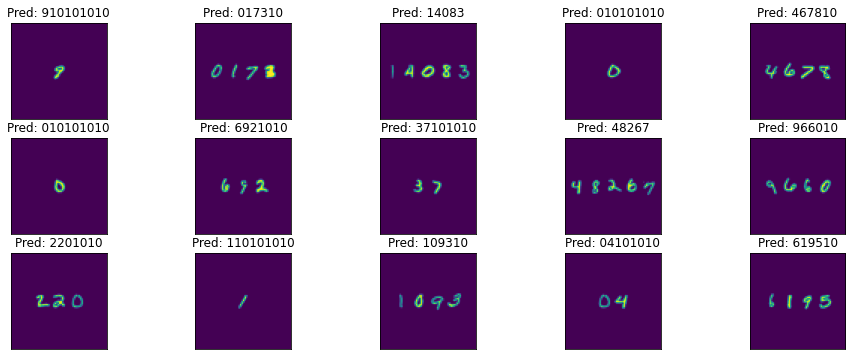

In [26]:
vi_test = np.array(hf["test_dataset"][:])
plot_images(vi_test, 3, 5, prediction)